In [1]:
import os
import numpy as np

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

import cv2

In [2]:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

import pandas as pd

In [46]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import ntpath
from tqdm import tqdm_notebook as tqdm
import sys
import SimpleITK as sitk
from radiomics import featureextractor
import numpy as np

In [48]:
def path2array(dcm_path, cut=True):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    if cut:
        arr = arr[8:-8,8:-8]
    return arr

In [3]:
def readDicom(path):
    pi = os.path.basename(path).split('_')[1]
    dcm_size = len(glob.glob(path+'/*.dcm'))
    dcms = [path+'/E'+pi+'S101I%d.dcm'%dicom_slicei for dicom_slicei in range(1,dcm_size+1)]
    dcm_f = pydicom.read_file(dcms[0]).pixel_array
    dcm_size = max(dcm_f.shape)
    dcm_img = np.zeros((dcm_size,dcm_size,len(dcms)))
    for dcmi in range(len(dcms)):
        cdcm = pydicom.read_file(dcms[dcmi]).pixel_array
        dcm_img[dcm_size//2-cdcm.shape[0]//2:dcm_size//2+cdcm.shape[0]//2,
                dcm_size//2-cdcm.shape[1]//2:dcm_size//2+cdcm.shape[1]//2,dcmi] = cdcm
    return dcm_img

In [10]:
img_dir = "C:/Users/E.Lavrova/Desktop/careIIChallenge/careIIChallenge/0_P125_U"

mask_gt_dir = "C:/Users/E.Lavrova/Desktop/careIIChallenge/masks/gt/0_P125_U"
mask_pred_dir = "C:/Users/E.Lavrova/Desktop/careIIChallenge/masks/pred/0_P125_U"

In [8]:
dcm_img = readDicom(img_dir)

In [17]:
filenames = os.listdir(mask_gt_dir)

In [53]:
'''i = 17

mask_gt = np.load(mask_gt_dir + '/' + filenames[i])
mask_pred = np.load(mask_pred_dir + '/' + filenames[i])

sl = int(filenames[i][:-4])

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(dcm_img[..., sl])
plt.contour(mask_gt, colors = 'r')
plt.subplot(132)
plt.imshow(dcm_img[..., sl])
plt.contour(mask_pred, colors = 'r')
plt.subplot(133)
plt.imshow(mask_gt)
plt.contour(mask_pred, colors = 'r')
plt.show()'''

"i = 17\n\nmask_gt = np.load(mask_gt_dir + '/' + filenames[i])\nmask_pred = np.load(mask_pred_dir + '/' + filenames[i])\n\nsl = int(filenames[i][:-4])\n\nplt.figure(figsize=(20, 20))\nplt.subplot(131)\nplt.imshow(dcm_img[..., sl])\nplt.contour(mask_gt, colors = 'r')\nplt.subplot(132)\nplt.imshow(dcm_img[..., sl])\nplt.contour(mask_pred, colors = 'r')\nplt.subplot(133)\nplt.imshow(mask_gt)\nplt.contour(mask_pred, colors = 'r')\nplt.show()"

In [47]:
def correctBiasField(img_input):
    
    corrected = False
    img_output = np.zeros(img_input.shape)

    while not corrected:

        try:
            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            inputImage = sitk.GetImageFromArray(img_input)
            inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
            output = corrector.Execute(inputImage)
            img_output = sitk.GetArrayFromImage(output)
            corrected = True
        except:
            print ('BFC failed')

    return img_output

In [59]:
img = path2array(r"I:\parisk_validation\validation_sets\EMC\EMC005\T1w_SER_0014_sl0009_ph0001.dcm")

img_min = np.min(img)
img_max = np.max(img)

img_norm = ((img.copy()-img_min)/(img_max-img_min)*255).astype(np.uint8)

In [61]:
img_bfc = correctBiasField(img_norm)

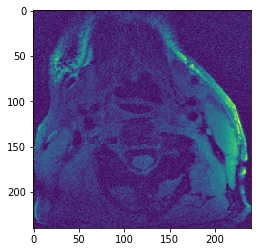

In [62]:
plt.imshow(img_bfc)
plt.show()

In [63]:
from skimage import exposure
from skimage import img_as_float

In [72]:
# Contrast stretching
p2, p98 = np.percentile(img_bfc, (2, 98))
img_rescale = exposure.rescale_intensity(img_bfc, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img_bfc)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img_bfc/255, clip_limit=0.0075)

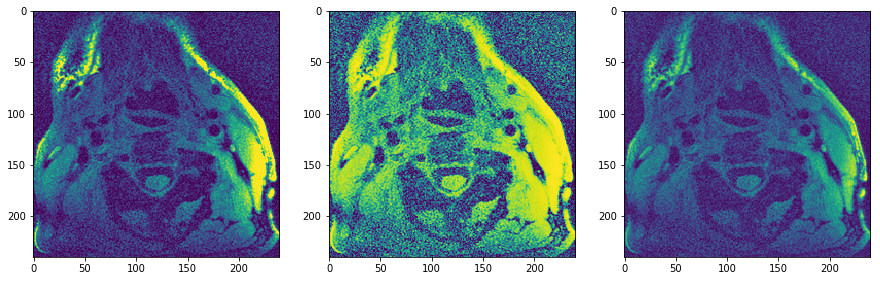

In [73]:
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img_rescale)
plt.subplot(132)
plt.imshow(img_eq)
plt.subplot(133)
plt.imshow(img_adapteq)
plt.show()